# Recommendations with IBM

This notebook implements different methods of recommender systems based on a data set of the IBM Watson Studio.

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


Convert the `article_id` to `str` data type with a formating as a float with one decimal.

In [2]:
df_content['article_id'] = df_content['article_id'].apply(lambda x: '%.1f'%x)

In [3]:
df['article_id'] = df['article_id'].apply(lambda x: '%.1f'%x)

In [4]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0.0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1.0
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2.0
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3.0
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4.0


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [5]:
usage_pivot = df.groupby(['email', 'article_id']).count().unstack().fillna(0)
usage_pivot.shape

(5148, 714)

In [6]:
# median for the article interactions of users
df.groupby('email')['article_id'].count().median()

3.0

In [7]:
# highest article interactions observed for a user
df.groupby('email').count()['article_id'].max()

364

In [8]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [9]:
# Find and explore duplicate articles
df_content.duplicated(subset=['article_id']).sum()

5

In [10]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id'], inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [11]:
# The number of unique articles that have an interaction with a user.
usage_pivot.apply(lambda x: x.sum() >= 1, axis=0).count()

714

In [12]:
# The number of unique articles on the IBM platform
df_content['article_id'].count()

1051

In [13]:
# The number of unique users
df['email'].describe()['unique']

5148

In [14]:
# The number of user-article interactions
len(df)

45993

In [15]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [16]:
views_per_article = usage_pivot.sum(axis=0)
max_id = views_per_article.values.argmax()
max_id

311

In [17]:
views_per_article[max_id]

937.0

In [18]:
views_per_article.index[max_id]

('title', '1429.0')

In [19]:
most_viewed_article_id = "1429.0" # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937# The most viewed article in the dataset was viewed how many times?

In [4]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [21]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [22]:
df.groupby('article_id').count().reset_index().sort_values(by='title', ascending=False).iloc[:5,0].tolist()

['1429.0', '1330.0', '1431.0', '1427.0', '1364.0']

In [23]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_ids = get_top_article_ids(n, df=df)

    top_articles = []
    for top_id in top_ids:
        top_articles.append(df[df['article_id'] == top_id]['title'].iloc[0])

    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df.groupby('article_id').count().reset_index().sort_values(by='title', ascending=False).iloc[:n,0].tolist()
    
    return top_articles # Return the top article ids

In [24]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [25]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [26]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Create a pivot table
    user_item = df.groupby(['user_id', 'article_id']).count().unstack().fillna(0)

    # Binarize the pivot table
    user_item = user_item.applymap(lambda x: 1 if x>0 else 0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [27]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [28]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarities = np.dot(user_item.iloc[0,:], user_item.T)
    uid_ind = [uid for uid in range(len(similarities))]
    
    dist_series = pd.Series(data=similarities, index=uid_ind)

    # sort by similarity
    most_similar_users = dist_series.sort_values(ascending=False)

    # create list of just the ids
    most_similar_users = most_similar_users.index.tolist()
   
    # remove the own user's id
    most_similar_users = most_similar_users[1:]
       
    return most_similar_users # return a list of the users in order from most to least similar

In [29]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3932, 22, 3781, 202, 4458, 130, 3869, 45, 4200, 5040]
The 5 most similar users to user 3933 are: [3932, 22, 3781, 202, 4458]
The 3 most similar users to user 46 are: [3932, 22, 3781]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [30]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = []
    for article_id in article_ids:
        try:
            article_name = df[df['article_id'] == article_id].iloc[0]['title']
            article_names.append(article_name)
        except Exception as e:
            print("Could not map article {}".format(article_id))
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids = user_item.loc[user_id][user_item.loc[user_id] != 0].title.index.tolist()

    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Articles already seen
    hist_article_ids, hist_article_names = get_user_articles(user_id)
    
    # Find similar users
    similar_users = find_similar_users(user_id)
    
    # Loops through the users based on closeness to the input user_id
    recs = set()
    for similar_user in similar_users:
        # Terminate if enough recommendations are found
        if len(recs) >= m:
            break
        
        # Articles clicked by the similar user
        candidate_article_ids, candidate_article_names = get_user_articles(similar_user)
        
        # Filter to only contain unseen articles
        rec = set(filter(lambda x: x not in hist_article_ids, candidate_article_ids))
        new_rec = rec - recs
        
        # Store in output array but
        space = m - len(new_rec)
        recs.update(list(new_rec)[:space])
    
    return list(recs) # return your recommendations for this user_id    

In [31]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['timeseries data analysis of iot events by using jupyter notebook',
 'this week in data science (february 7, 2017)',
 'upload files to ibm data science experience using the command line',
 'programmatic evaluation using watson conversation',
 'pulling and displaying etf data',
 'predicting churn with the spss random tree algorithm',
 'gosales transactions for logistic regression model',
 'deep learning from scratch i: computational graphs',
 'tidy up your jupyter notebooks with scripts',
 'deploy your python model as a restful api',
 'analyze traffic data from the city of san francisco',
 'data visualization with ggplot2 cheat sheet',
 'using github for project control in dsx',
 'deep learning with data science experience']

In [32]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [33]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # compute similarity of each user to the provided user
    similarities = np.dot(user_item.iloc[0,:], user_item.T)
    
    # item interactions for each user
    interactions = user_item.sum(axis=1)
    
    # create a DataFrame
    d = {'neighbor_id':interactions.index.values,
         'similarity':similarities,
         'num_interactions':interactions.values}
    neighbors_df = pd.DataFrame(data=d)
    
    # sort the values
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'],
                             ascending=False)
    
    # drop the first entry as this is the user itself
    neighbors_df = neighbors_df.iloc[1:]
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Articles already seen
    hist_article_ids, hist_article_names = get_user_articles(user_id)
    
    # Find similar users
    similar_users = get_top_sorted_users(user_id).neighbor_id.tolist()
    
    # total item interactions
    item_interaction_cnt = user_item.sum(axis=0).reset_index().drop(columns=['level_0']).set_index('article_id')[0]
    
    # Loops through the users based on closeness to the input user_id
    recs = set()
    for similar_user in similar_users:
        # Terminate if enough recommendations are found
        if len(recs) >= m:
            break
        # Articles clicked by the similar user
        candidate_article_ids, _ = get_user_articles(similar_user)
        
        # Filter to only contain unseen articles
        rec = set(filter(lambda x: x not in hist_article_ids, candidate_article_ids))
        new_rec = rec - recs
        
        # Sort according to the most total interactions
        interact_count = []
        for x in new_rec:
            interact_count.append(item_interaction_cnt[x])

        items = pd.Series(interact_count)
        items.index = new_rec
        
        items = items.sort_values(ascending=False)
        
        # Store in output array but
        space = m - len(new_rec)
        recs.update(items[:space].index.tolist())
        
    #recs = list(map(lambda x: '%.1f'%x, recs))
    rec_names = get_article_names(recs)
    return recs, rec_names

In [34]:
get_user_articles(20)

(['1320.0', '232.0', '844.0'],
 ['housing (2015): united states demographic measures',
  'self-service data preparation with ibm data refinery',
  'use the cloudant-spark connector in python notebook'])

In [35]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
{'1429.0', '1430.0', '43.0', '1170.0', '1431.0', '1436.0', '1185.0', '1368.0', '1293.0', '1427.0'}

The top 10 recommendations for user 20 are the following article names:
['use deep learning for image classification', 'using pixiedust for fast, flexible, and easier data analysis and experimentation', 'deep learning with tensorflow course by big data university', 'apache spark lab, part 1: basic concepts', 'visualize car data with brunel', 'welcome to pixiedust', 'classify tumors with machine learning', 'putting a human face on machine learning', 'finding optimal locations of new store using decision optimization', 'use xgboost, scikit-learn & ibm watson machine learning apis']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [36]:
# Find the user that is most similar to user 1 
get_top_sorted_users(1).head(1)

,neighbor_id,similarity,num_interactions
3932,3933,35,35


In [37]:
# Find the 10th most similar user to user 131
get_top_sorted_users(131).iloc[9]

neighbor_id          49
similarity           12
num_interactions    101
Name: 48, dtype: int64

In [38]:
### Tests with a dictionary of results

user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 49# Find the 10th most similar user to user 131

In [56]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

TypeError: 'int' object is not iterable

`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Given a new user, it is not possible to calculate the similarity to the other users, as this new user has no item interactions yet (cold start problem). Thus, we cannot find the most similar user. Instead, we need to apply rank-based recommendations, for example with the method `get_top_articles(...)`. Additionally, it could be considered to offer knowledge-based filtering, where the customer could select some filter criteria to only see articles that he is interested in.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [40]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(n=10) # Your recommendations here

In [41]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [5]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [6]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [7]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

*** In the lesson, the user_item_matrix contained ratings. In case a user did not rate an item yet, we wanted to predict his rating. However, in the IBM Watson Studio scenario, the matrix contains the information whether a user already clicked at an item or not. For those items that were not clicked yet, we want to predict whether the user will click in the future. The difference is that in this case (compared to the lesson) the SVD algorithm is defined, as the user_item_matrix contains no nan values, but only 0 or 1.***

**Provide your response here.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

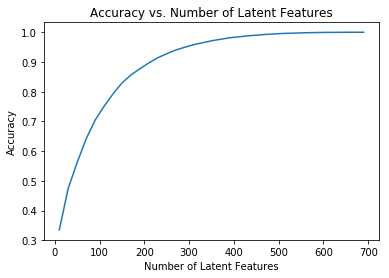

In [8]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [9]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Create user-item matrices for train and test
    user_item_train = df_train.groupby(['user_id', 'article_id']).count().unstack().fillna(0)
    user_item_test = df_test.groupby(['user_id', 'article_id']).count().unstack().fillna(0)
    
    # Calculate all test user ids
    test_idx = df_test['user_id'].unique().tolist()
    
    # Calculate all test article ids
    test_arts = df_test['article_id'].unique().tolist()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [10]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,# letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,# letter here, 
    'How many movies can we make predictions for in the test set?': b,# letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d# letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [11]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [12]:
row_idxs = user_item_train.index.isin(test_idx)
col_idxs = user_item_train['title'].columns.isin(test_arts)
u_test = u_train[row_idxs, :]
vt_test = vt_train[:, col_idxs]

In [13]:
# Unique users and articles of the training data 
train_idx = df_train['user_id'].unique().tolist()
train_arts = df_train['article_id'].unique().tolist()

# Create a sub-matrix of user_item_test based on the overlapping users and items between test and train
test_idx = user_item_test.index.isin(train_idx)
test_cols = user_item_test['title'].columns.isin(test_arts)
user_item_test = user_item_test.loc[test_idx, test_cols]

In [14]:
user_item_train.shape[0]

4487

In [15]:
user_item_test.shape[1]

574

In [16]:
from sklearn.metrics import accuracy_score

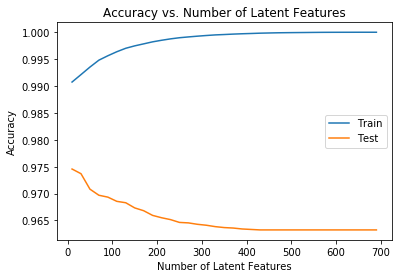

In [18]:
num_latent_feats = np.arange(10,700+10,20)
sum_accs_train = []
sum_accs_test = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))

    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_preds)
    diffs_test = np.subtract(user_item_test, user_item_test_preds)
    
    # total errors and keep track of them
    acc_train = accuracy_score(user_item_train.values.flatten(), user_item_train_preds.flatten())
    acc_test = accuracy_score(user_item_test.values.flatten(), user_item_test_preds.flatten())
    
    sum_accs_train.append(acc_train)
    sum_accs_test.append(acc_test)

# Plot the accuracy
plt.plot(num_latent_feats, sum_accs_train, label='Train');
plt.plot(num_latent_feats, sum_accs_test, label='Test');
plt.legend()

plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

The results indicate that the number of latent features highly influences the overfitting of the model. The higher the number of latent features, the better the reconstruction of the training matrix. However, this impacts how well the model is able to generalize. Consequently, the accuracy on the Test data set decreases with higher numbers of latent features. The high accuaracy values come from the inbalanced classes of `0` and `1` in the data sets. For example only 2.8% of the `user_item_matrix` of the test data set contain a `1`.

A possible approach to evaluate the recommendation engine in practice is to do an A/B deployment. Following this way, user group A is shown the recommendations, whereby user group B has no access to the recommendations. In this case, the purpose of the recommendation engine should be to increase the number of articles the usesr interact with. For that, the approach could be to compute the mean value of user-article interactions for both groups A/B. Based on these values, a hypothesis test can be conducted. The null hypothesis could be that there is no significant difference regarding the number of user-article interactions among both groups A/B.

In [1]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0